In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr
import xarray as xr
from cartopy import crs, feature

In [2]:
ds = xr.open_dataset('dataset.nc')

In [3]:
ds

<xarray.Dataset>
Dimensions:    (time: 14608, longitude: 173, latitude: 97)
Coordinates:
  * time       (time) datetime64[ns] 2014-01-01 ... 1900-01-01
  * longitude  (longitude) float32 -28.0 -27.75 -27.5 -27.25 ... 14.5 14.75 15.0
  * latitude   (latitude) float32 28.0 27.75 27.5 27.25 ... 4.75 4.5 4.25 4.0
Data variables:
    blh        (time, latitude, longitude) float64 ...
    z          (time, latitude, longitude) float64 ...
    slhf       (time, latitude, longitude) float64 ...
    sshf       (time, latitude, longitude) float64 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.10 (https://mpimet.mpg.d...
    Conventions:  CF-1.6
    history:      Wed Jun 19 07:44:54 2024: cdo -b F64 mergetime dat_2014.nc ...
    CDO:          Climate Data Operators version 1.9.10 (https://mpimet.mpg.d...

In [4]:
%time
slh = ds['slhf']/3600
ssh = ds['sshf']/3600
Blh=ds['blh']

CPU times: total: 0 ns
Wall time: 0 ns


In [ ]:
# Extract the variables as numpy arrays or pandas DataFrames
X1 = ssh.values
X2 = slh.values
Y = Blh.values

# You might want to flatten the arrays if they are multi-dimensional
X1_flat = X1.flatten()
X2_flat = X2.flatten()
Y_flat = Y.flatten()

# Combine independent variables into a single DataFrame or array
import pandas as pd

X = pd.DataFrame({
    'X1': X1_flat,
    'X2': X2_flat
})


In [ ]:
import statsmodels.api as sm

# Add a constant to the independent variables
X11 = sm.add_constant(X)

# Fit the model
model = sm.OLS(Y_flat, X).fit()

# Print the summary
print(model.summary())


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the model
model = LinearRegression()

# Fit the model
model.fit(X, Y_flat)

# Make predictions
Y_pred = model.predict(X)

# Evaluate the model
print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)
print('Mean squared error (MSE): %.2f' % mean_squared_error(Y_flat, Y_pred))
print('Coefficient of determination (R^2): %.2f' % r2_score(Y_flat, Y_pred))


In [5]:
BLH = Blh.mean(dim=['longitude', 'latitude']).groupby('time.hour').mean('time')  # Boundary Layer Height
SLH = slh.mean(dim=['longitude', 'latitude']).groupby('time.hour').mean('time')  # Latent Heat Flux
SSH = ssh.mean(dim=['longitude', 'latitude']) .groupby('time.hour').mean('time') # Sensible Heat Flux

In [6]:
SSH

<xarray.DataArray 'sshf' (hour: 4)>
array([   8.45417714,    7.85588374, -143.3890239 ,   -4.06192148])
Coordinates:
  * hour     (hour) int64 0 6 12 18

In [7]:
blh=Blh.groupby('time.hour').mean('time')
Ssh=ssh.groupby('time.hour').mean('time')
Slh=slh.groupby('time.hour').mean('time')

In [8]:
ds_hr=xr.merge([blh,Ssh,Slh])

In [9]:
ds_hr

<xarray.Dataset>
Dimensions:    (longitude: 173, latitude: 97, hour: 4)
Coordinates:
  * longitude  (longitude) float32 -28.0 -27.75 -27.5 -27.25 ... 14.5 14.75 15.0
  * latitude   (latitude) float32 28.0 27.75 27.5 27.25 ... 4.75 4.5 4.25 4.0
  * hour       (hour) int64 0 6 12 18
Data variables:
    blh        (hour, latitude, longitude) float64 723.6 722.4 ... 106.9 110.2
    sshf       (hour, latitude, longitude) float64 -7.509 -7.507 ... 6.873 7.289
    slhf       (hour, latitude, longitude) float64 -99.65 -99.44 ... -8.658
Attributes:
    long_name:  Boundary layer height
    units:      m

In [10]:

# Calculate maximum and minimum values for each variable
blh_max = ds_hr['blh'].max().values
blh_min = ds_hr['blh'].min().values

sshf_max = ds_hr['sshf'].max().values
sshf_min = ds_hr['sshf'].min().values

slhf_max = ds_hr['slhf'].max().values
slhf_min = ds_hr['slhf'].min().values

# Print the results
print(f"BLH Max: {blh_max}, BLH Min: {blh_min}")
print(f"SSHF Max: {sshf_max}, SSHF Min: {sshf_min}")
print(f"SLHF Max: {slhf_max}, SLHF Min: {slhf_min}")


BLH Max: 2814.4459468492305, BLH Min: 18.607527745243885
SSHF Max: 33.49979859194187, SSHF Min: -363.9011834535592
SLHF Max: 2.027658015812676, SLHF Min: -328.03186440849237


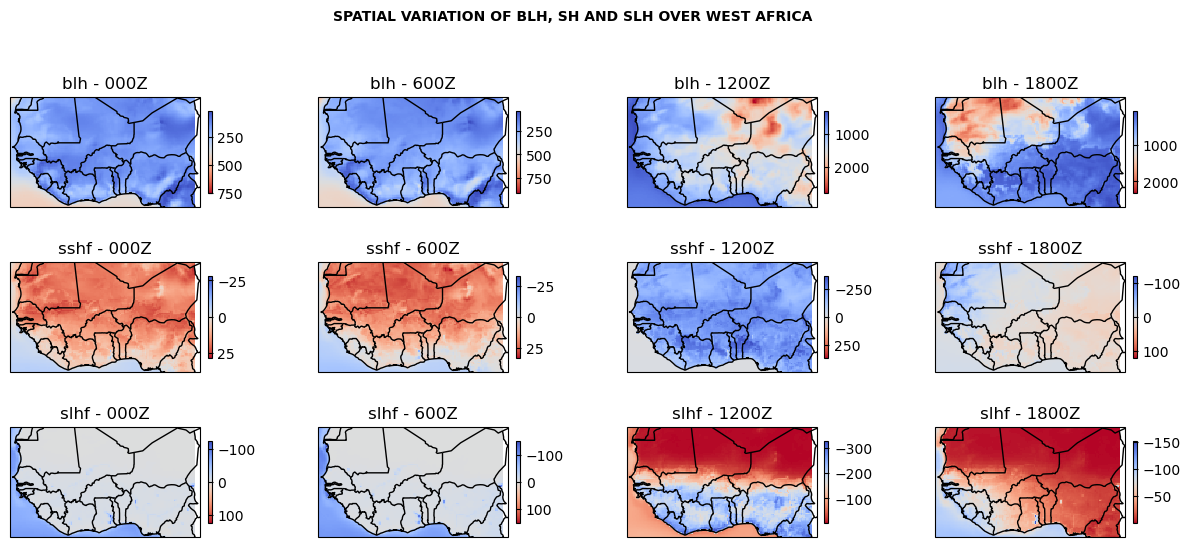

In [11]:
fig, axes = plt.subplots(nrows=len(ds_hr.data_vars), 
                        ncols=len(ds_hr.hour.values), figsize=(15,15),
                        subplot_kw={'projection':crs.PlateCarree()})
plt.subplots_adjust(hspace=-0.8, wspace=.3)

for i, var in enumerate(ds_hr.data_vars):
    for j, hour in enumerate(ds_hr.hour.values):
        cs=ds_hr[var].sel(hour=hour).plot(ax=axes[i,j], cmap='coolwarm', add_colorbar=False)
        axes[i,j].set_title(f"{var} - {hour}00Z")
        axes[i,j].coastlines()
        axes[i,j].add_feature(feature.BORDERS)
        # axes[i,j].set_extent([-25,57,-38,38])
        axes[i,j].set_extent([-18,16,4,23])
        plt.colorbar(cs,shrink=-0.1)        
plt.suptitle('SPATIAL VARIATION OF BLH, SH AND SLH OVER WEST AFRICA', fontweight='bold',fontsize=10, y=0.7)
plt.savefig('SPATIAL VARIATION OF BLH, SH AND SLH OVER WEST AFRICA')
plt.show()

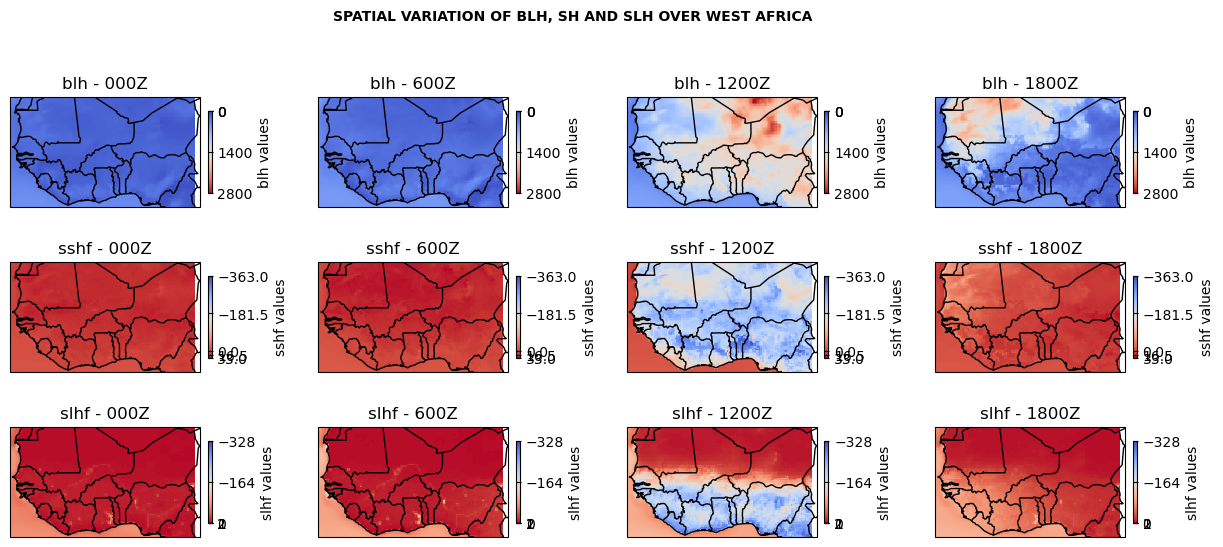

In [12]:

var_min_max = {
    'blh': {'min':0, 'max': 2800},
    'sshf': {'min': -363, 'max':33},
    'slhf': {'min': -328, 'max':2}
}

fig, axes = plt.subplots(nrows=len(ds_hr.data_vars), 
                        ncols=len(ds_hr.hour.values), figsize=(15,15),
                        subplot_kw={'projection': crs.PlateCarree()})
plt.subplots_adjust(hspace=-0.8, wspace=.3)

for i, var in enumerate(ds_hr.data_vars):
    for j, hour in enumerate(ds_hr.hour.values):
        vmin = var_min_max[var]['min']
        vmax = var_min_max[var]['max']
        
        cs = ds_hr[var].sel(hour=hour).plot(ax=axes[i,j], 
                                            cmap='coolwarm', 
                                            vmin=vmin, 
                                            vmax=vmax, 
                                            add_colorbar=False)
        axes[i,j].set_title(f"{var} - {hour}00Z")
        axes[i,j].coastlines()
        axes[i,j].add_feature(feature.BORDERS)
        axes[i,j].set_extent([-18,16,4,23])
        cbar = plt.colorbar(cs, ax=axes[i,j], shrink=-0.1, ticks=[vmin, vmin/2, 0, vmax/2, vmax])
        cbar.set_label(f"{var} values")

# Adding a global title
plt.suptitle('SPATIAL VARIATION OF BLH, SH AND SLH OVER WEST AFRICA',fontweight ='bold', fontsize=10, y=0.7)
plt.savefig('SPATIAL VARIATION OF BLH, SH AND SLH OVER WEST AFRICA(1)')
plt.show()


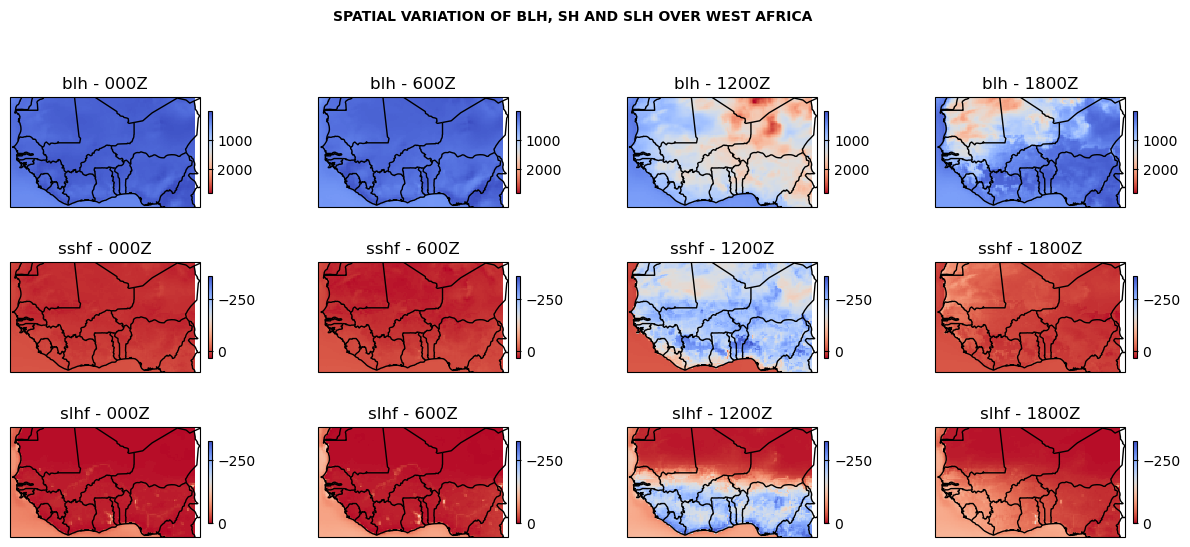

In [13]:

# Assume ds_hr is already loaded and available

# Calculate min and max for each variable
var_min_max = {}
for var in ds_hr.data_vars:
    var_min_max[var] = {
        'min': ds_hr[var].min().values,
        'max': ds_hr[var].max().values
    }

fig, axes = plt.subplots(nrows=len(ds_hr.data_vars), 
                        ncols=len(ds_hr.hour.values), figsize=(15,15),
                        subplot_kw={'projection': crs.PlateCarree()})
plt.subplots_adjust(hspace=-0.8, wspace=.3)

for i, var in enumerate(ds_hr.data_vars):
    for j, hour in enumerate(ds_hr.hour.values):
        # Get min and max values for the current variable
        vmin = var_min_max[var]['min']
        vmax = var_min_max[var]['max']
        
        cs = ds_hr[var].sel(hour=hour).plot(ax=axes[i,j], 
                                            cmap='coolwarm', 
                                            vmin=vmin, 
                                            vmax=vmax, 
                                            add_colorbar=False)
        axes[i,j].set_title(f"{var} - {hour}00Z")
        axes[i,j].coastlines()
        axes[i,j].add_feature(feature.BORDERS)
        # axes[i,j].set_extent([-25,57,-38,38])
        axes[i,j].set_extent([-18,16,4,23])
        plt.colorbar(cs, ax=axes[i,j], shrink=-0.1)
plt.suptitle('SPATIAL VARIATION OF BLH, SH AND SLH OVER WEST AFRICA',fontweight='bold', fontsize=10, y=0.7)
plt.savefig('SPATIAL VARIATION OF BLH, SH AND SLH OVER WEST AFRICA(2)')
plt.show()

In [14]:
LH = slh.mean(dim=['longitude', 'latitude'])
SH = ssh.mean(dim=['longitude', 'latitude'])
BH = Blh.mean(dim=['longitude', 'latitude'])

In [15]:
BH

<xarray.DataArray 'blh' (time: 14608)>
array([380.59697342, 362.61973493, 820.83649493, ...,   0.        ,
         0.        ,   0.        ])
Coordinates:
  * time     (time) datetime64[ns] 2014-01-01 2014-01-01T06:00:00 ... 1900-01-01

In [16]:
# Calculate statistics for planetary boundary layer (blh)
blh_mean = Blh.mean().values
blh_median = Blh.median().values
blh_variance = Blh.var().values
blh_std_dev = Blh.std().values
blh_iqr = Blh.quantile(0.75).values - Blh.quantile(0.25).values

# Calculate statistics for sensible heat flux (sshf)
sshf_mean = ssh.mean().values
sshf_median = ssh.median().values
sshf_variance = ssh.var().values
sshf_std_dev = ssh.std().values
sshf_iqr = ssh.quantile(0.75).values - ssh.quantile(0.25).values

# Calculate statistics for latent heat flux (slhf)
slhf_mean = slh.mean().values
slhf_median = slh.median().values
slhf_variance = slh.var().values
slhf_std_dev = slh.std().values
slhf_iqr = slh.quantile(0.75).values - slh.quantile(0.25).values

# Create a DataFrame to display the statistics
data = {
    'Variable': ['Planetary Boundary Layer (BLH)', 'Sensible Heat Flux (SSHf)', 'Latent Heat Flux (SLHf)'],
    'Mean': [blh_mean, sshf_mean, slhf_mean],
    'Median': [blh_median, sshf_median, slhf_median],
    'Variance': [blh_variance, sshf_variance, slhf_variance],
    'Standard Deviation': [blh_std_dev, sshf_std_dev, slhf_std_dev],
    'Inter Quartile Range (IQR)': [blh_iqr, sshf_iqr, slhf_iqr]
}

df = pd.DataFrame(data)

# Print the DataFrame
df


,Variable,Mean,Median,Variance,Standard Deviation,Inter Quartile Range (IQR)
0,Planetary Boundary Layer (BLH),602.3330412113012,421.1592383393363,498567.8247879886,706.0933541593411,605.426733
1,Sensible Heat Flux (SSHf),-30.16545488751803,-0.33667095203945385,7503.48344229203,86.6226497071755,23.228755
2,Latent Heat Flux (SLHf),-51.10182035042398,-8.117227753786493,5372.24351220027,73.29558999148769,84.720378


In [17]:
BLH_month = Blh.mean(dim=['longitude', 'latitude']).groupby('time.month').mean('time')  # Boundary Layer Height
SLH_month = slh.mean(dim=['longitude', 'latitude']).groupby('time.month').mean('time')  # Latent Heat Flux
SSH_month = ssh.mean(dim=['longitude', 'latitude']) .groupby('time.month').mean('time') # Sensible Heat Flux

In [18]:
BLH_month

<xarray.DataArray 'blh' (month: 12)>
array([278.6174305 , 556.07241045, 640.42694978, 720.28269512,
       783.51420267, 780.32137836, 805.11059687, 744.44204726,
       655.23111683, 571.11424625, 502.60502545, 477.68045845])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [19]:
# Selecting climatic Zones for SURFACE SENSIBLE HEAT FLUX
Sahel_zone_SH=ds.sshf.sel(longitude=slice(-18,18),latitude=slice(16,12))/3600
Guinea_zone_SH=ds.sshf.sel(longitude=slice(-18,18),latitude=slice(8,4))/3600
Sudan_zone_SH=ds.sshf.sel(longitude=slice(-18,18),latitude=slice(20,16))/3600
Sudano_Sahelian_SH=ds.sshf.sel(longitude=slice(-18,18),latitude=slice(12,8))/3600

In [20]:
# Diurnal Variation of Zones Variables OF SURFACE HEAT FLUX
SZ_SH= Sudan_zone_SH.mean(dim=['longitude', 'latitude']).groupby('time.hour').mean('time')
SS_SH= Sudano_Sahelian_SH.mean(dim=['longitude', 'latitude']).groupby('time.hour').mean('time')
GZ_SH= Guinea_zone_SH.mean(dim=['longitude', 'latitude']).groupby('time.hour').mean('time')
SHZ_SH= Sahel_zone_SH.mean(dim=['longitude', 'latitude']).groupby('time.hour').mean('time')

In [21]:
# Seasonal Variation of Zones Variables OF SURFACE HEAT FLUX
SZ_SH_month=Sudan_zone_SH.mean(dim=['longitude', 'latitude']).groupby('time.month').mean('time')
SS_SH_month=Sudano_Sahelian_SH.mean(dim=['longitude', 'latitude']).groupby('time.month').mean('time')
GZ_SH_month=Guinea_zone_SH.mean(dim=['longitude', 'latitude']).groupby('time.month').mean('time')
SHZ_SH_month=Sahel_zone_SH.mean(dim=['longitude', 'latitude']).groupby('time.month').mean('time')

In [22]:
# Selecting climatic Zones for boundary layer Height 
Sahel_zone_BLH=ds.blh.sel(longitude=slice(-18,18),latitude=slice(16,12))
Guinea_zone_BLH=ds.blh.sel(longitude=slice(-18,18),latitude=slice(8,4))
Sudan_zone_BLH=ds.blh.sel(longitude=slice(-18,18),latitude=slice(20,16))
Sudano_Sahelian_BLH=ds.blh.sel(longitude=slice(-18,18),latitude=slice(12,8))

In [23]:
# Diurnal Variation of Zones Variables OF BLH
SZ_BLH = Sudan_zone_BLH.mean(dim=['longitude', 'latitude']).groupby('time.hour').mean('time')
SS_BLH = Sudano_Sahelian_BLH.mean(dim=['longitude', 'latitude']).groupby('time.hour').mean('time')
GZ_BLH = Guinea_zone_BLH.mean(dim=['longitude', 'latitude']).groupby('time.hour').mean('time')
SHZ_BLH = Sahel_zone_BLH.mean(dim=['longitude', 'latitude']).groupby('time.hour').mean('time')

In [24]:
# Seasonal Variation of Zones Variables OF BOUNDARY LAYER HEIGHT
SZ_BLH_month=Sudan_zone_BLH.mean(dim=['longitude', 'latitude']).groupby('time.month').mean('time')
SS_BLH_month=Sudano_Sahelian_BLH.mean(dim=['longitude', 'latitude']).groupby('time.month').mean('time')
GZ_BLH_month=Guinea_zone_BLH.mean(dim=['longitude', 'latitude']).groupby('time.month').mean('time')
SHZ_BLH_month=Sahel_zone_BLH.mean(dim=['longitude', 'latitude']).groupby('time.month').mean('time')

In [25]:
# # Selecting climatic Zones for SURFACE LATENT HEAT FLUX
Sahel_zone_SLH=ds.slhf.sel(longitude=slice(-18,18),latitude=slice(16,12))/3600
Guinea_zone_SLH=ds.slhf.sel(longitude=slice(-18,18),latitude=slice(8,4))/3600
Sudan_zone_SLH=ds.slhf.sel(longitude=slice(-18,18),latitude=slice(20,16))/3600
Sudano_Sahelian_SLH=ds.slhf.sel(longitude=slice(-18,18),latitude=slice(12,8))/3600

In [26]:
# Diurnal Variation of Zones Variables OF SURFACE LATENT HEAT FLUX
SZ_SLH=Sudan_zone_SLH.mean(dim=['longitude', 'latitude']).groupby('time.hour').mean('time')
SS_SLH=Sudano_Sahelian_SLH.mean(dim=['longitude', 'latitude']).groupby('time.hour').mean('time')
GZ_SLH=Guinea_zone_SLH.mean(dim=['longitude', 'latitude']).groupby('time.hour').mean('time')
SHZ_SLH=Sahel_zone_SLH.mean(dim=['longitude', 'latitude']).groupby('time.hour').mean('time')

In [27]:
# Seasonal Variation of Zones Variables OF SURFACE LATENT HEAT FLUX
SZ_SLH_month=Sudan_zone_SLH.mean(dim=['longitude', 'latitude']).groupby('time.month').mean('time')
SS_SLH_month=Sudano_Sahelian_SLH.mean(dim=['longitude', 'latitude']).groupby('time.month').mean('time')
GZ_SLH_month=Guinea_zone_SLH.mean(dim=['longitude', 'latitude']).groupby('time.month').mean('time')
SHZ_SLH_month=Sahel_zone_SLH.mean(dim=['longitude', 'latitude']).groupby('time.month').mean('time')

In [ ]:
# Sahel=xr.merge([SHZ_BLH,SHZ_SH,SHZ_SLH])

In [28]:
SHZ_SLH_month

<xarray.DataArray 'slhf' (month: 12)>
array([-13.63962292, -19.94106131, -17.4036849 , -17.57532748,
       -25.07882503, -41.41560109, -65.03543752, -83.07222496,
       -80.11026821, -58.44416046, -41.19083659, -30.33541173])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [ ]:
# sudan
SZ_SH_month = -12.40565315, -27.94220331, -36.04202327, -41.08450258,-44.42686205, -47.71162878, -55.40645402, -52.00928612,-45.47098052, -35.17250044, -26.31986715, -20.78679623
SZ_BLH_month = 209.35817631, 436.4701452 , 530.79506069, 704.23973801,907.1676808 , 967.740367  , 934.49790603, 838.52782673,823.51805494, 673.81412274, 413.17598591, 361.68754233
SZ_SLH_month = -4.87738698,  -7.18342269,  -6.06375472,  -5.96361746,-6.64987709,  -8.4952557 , -13.62630032, -26.12564437, -17.48503685, -11.1927724 , -10.24696486, -10.13943769

# Sudano_Sahelian
SS_SH_month = -30.17136178, -62.75771257, -72.38158727, -71.16311681,-56.36724791, -38.94636414, -27.0883778 , -20.54627171,-23.86450949, -31.83535542, -41.5018762 , -46.32133355
SS_BLH_month = 249.70251755, 522.94837402, 665.3583472 , 704.0639812 ,614.61644229, 527.34291704, 469.90612984, 431.37526384, 378.83804985, 427.03092236, 488.57024284, 439.40279609
SS_SLH_month = -26.34462811, -40.11319283, -41.86403963, -52.02360857,-69.92846973, -82.37734856, -89.23220873, -88.91411564,-94.09226429, -93.09121469, -73.97573585, -56.20137292

# Guinea_zone
GZ_SH_month = -25.37209521, -48.34492059, -41.11312383, -32.86288356,-26.2881896 , -21.44326938, -19.82970666, -19.60379494,-19.67753785, -21.80991174, -26.81608327, -35.34081902
GZ_BLH_month = 300.45097344, 568.30776127, 565.16963689, 523.88964553,472.06140644, 479.1772071 , 525.59981109, 523.58091645,440.40959454, 415.18264562, 455.43662175, 484.04830506
GZ_SLH_month = -36.88643172, -63.27734122, -74.57393571, -83.82638225,-86.87917315, -89.9763389 , -90.58804695, -84.05001997,-79.25543273, -81.60172007, -81.84835621, -71.4867231 

#  Sahel 
SHZ_SH_month = -20.67451448, -43.40367163, -54.54722591, -63.55599106,-67.68578085, -64.32918141, -48.82370857, -30.1370594 ,-35.1185858 , -40.72490068, -36.22668184, -33.45346843
SHZ_BLH_month = 225.31219231, 484.30051542, 641.16436587, 842.34788313,884.07816788, 794.09604507, 673.3363259 , 530.89297006,520.85857944, 579.17107544, 467.65767088, 390.14763793
SHZ_SLH_month = -13.63962292, -19.94106131, -17.4036849 , -17.57532748,-25.07882503, -41.41560109, -65.03543752, -83.07222496,-80.11026821, -58.44416046, -41.19083659, -30.33541173

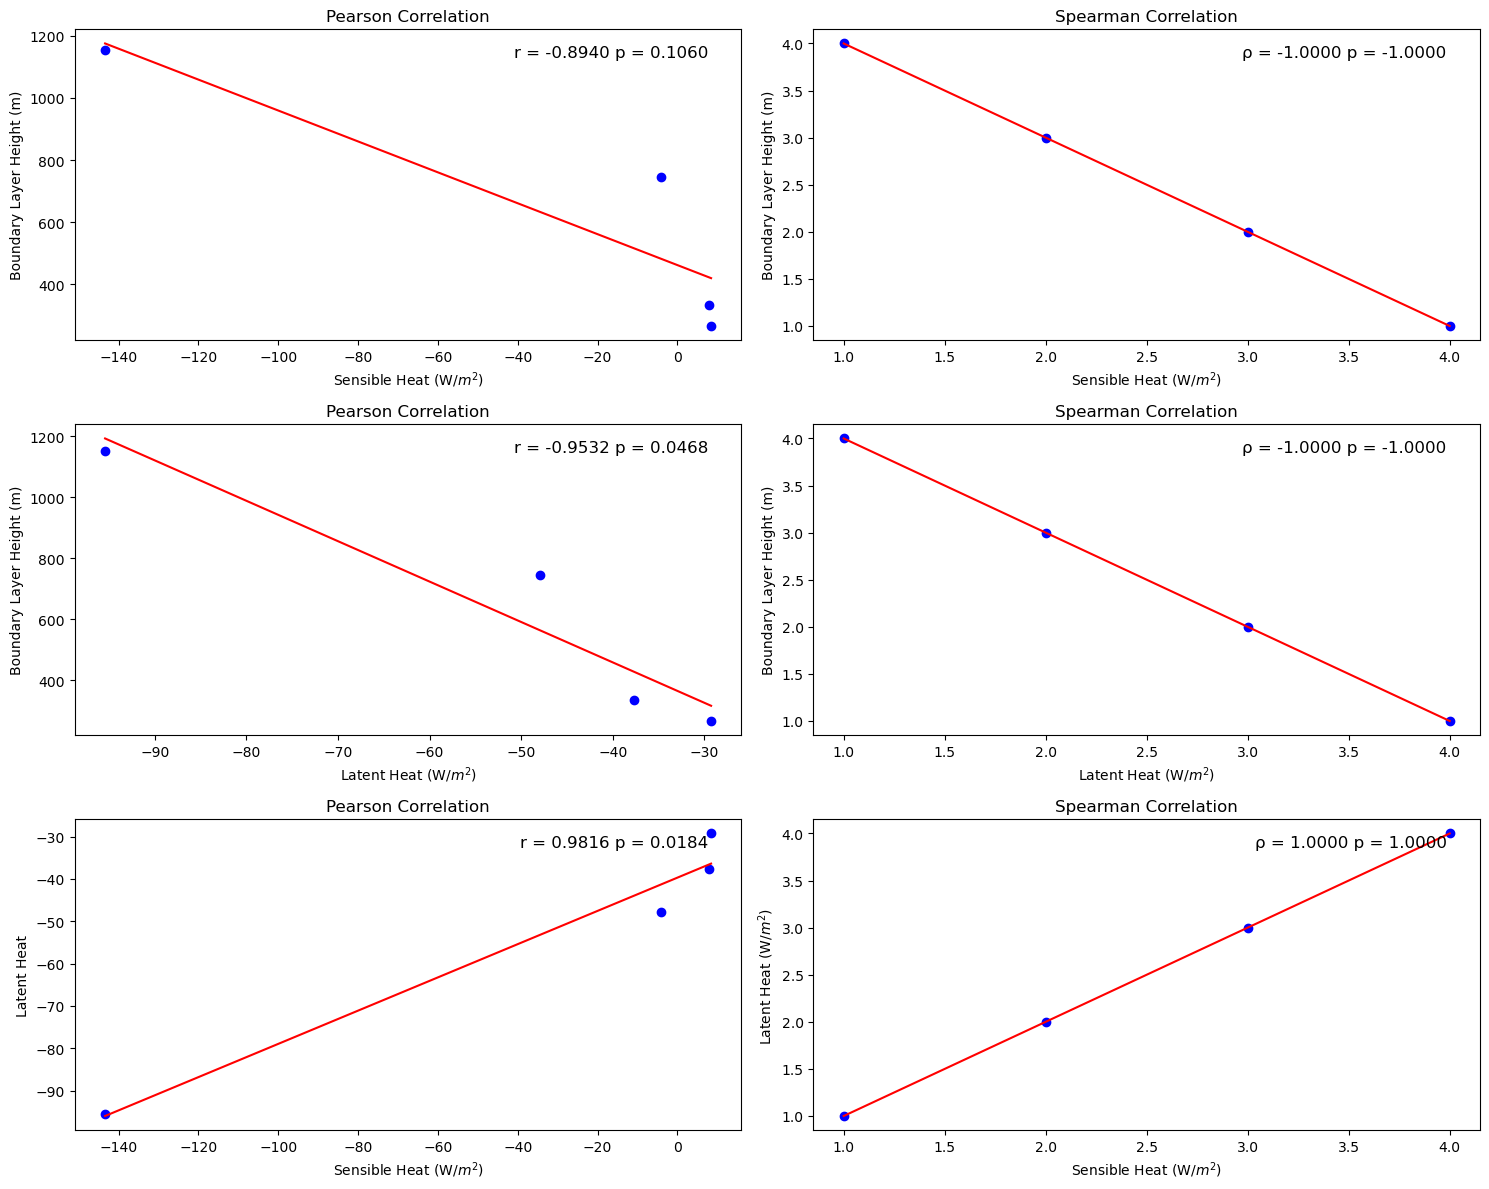

In [29]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))

# Plot on the first subplot (0,0)
ax1 = axes[0, 0]
pearson_corr, pearson_p = pearsonr(SSH,BLH)
ax1.scatter(SSH, BLH, color='b')
axes[0, 0].plot(np.unique(SSH), np.poly1d(np.polyfit(SSH, BLH, 1))(np.unique(SSH)), color='r')
axes[0, 0].set_title('Pearson Correlation')
axes[0, 0].set_xlabel('Sensible Heat (W/$m^2$)')
axes[0, 0].set_ylabel('Boundary Layer Height (m)')
ax1.text(0.95, 0.95, f'r = {pearson_corr:.4f} p = {pearson_p:.4f}',
         fontsize=12, color='black', ha='right', va='top',
         transform=ax1.transAxes)

ax2=axes[1,0]
pearson_corr, pearson_p = pearsonr(SLH,BLH)
ax2.scatter(SLH, BLH, color='b')
ax2.plot(np.unique(SLH), np.poly1d(np.polyfit(SLH, BLH, 1))(np.unique(SLH)), color='r')
ax2.set_title('Pearson Correlation')
ax2.set_xlabel('Latent Heat (W/$m^2$)')
ax2.set_ylabel('Boundary Layer Height (m)')
ax2.text(0.95, 0.95, f'r = {pearson_corr:.4f} p = {pearson_p:.4f}',
         fontsize=12, color='black', ha='right', va='top',
         transform=ax2.transAxes)

ax3=axes[2,0]
pearson_corr, pearson_p = pearsonr(SSH,SLH)
ax3.scatter(SSH, SLH, color='b')
ax3.plot(np.unique(SSH), np.poly1d(np.polyfit(SSH, SLH, 1))(np.unique(SSH)), color='r')
ax3.set_title('Pearson Correlation')
ax3.set_xlabel('Sensible Heat (W/$m^2$)')
ax3.set_ylabel('Latent Heat')
ax3.text(0.95, 0.95, f'r = {pearson_corr:.4f} p = {pearson_p:.4f}',
         fontsize=12, color='black', ha='right', va='top',
         transform=ax3.transAxes)


SSH_rank = SSH.rank(dim='hour')
BLH_rank = BLH.rank(dim='hour')
SLH_rank = SLH.rank(dim='hour')
# Flatten the DataArrays for correlation and plotting
SSH_rank_flat = SSH_rank.values.flatten()
BLH_rank_flat = BLH_rank.values.flatten()
SLH_rank_flat = SLH_rank.values.flatten()
# Compute Spearman correlation
spearman_corr, spearman_p = spearmanr(SSH_rank_flat, BLH_rank_flat)

spearman_corr, spearman_p = spearmanr(SSH, BLH)
axes[0,1].scatter(SSH_rank_flat, BLH_rank_flat, color='b')
# Fit line
fit_line = np.poly1d(np.polyfit(SSH_rank_flat, BLH_rank_flat, 1))
axes[0,1].plot(np.unique(SSH_rank_flat), fit_line(np.unique(SSH_rank_flat)), color='r')

# Set titles and labels
axes[0,1].set_title('Spearman Correlation')
axes[0,1].set_xlabel('Sensible Heat (W/$m^2$)')
axes[0,1].set_ylabel('Boundary Layer Height (m)')
axes[0,1].text(0.95, 0.95, f'ρ = {spearman_corr:.4f} p = {spearman_corr:.4f}',
         fontsize=12, color='black', ha='right', va='top',
         transform=axes[0,1].transAxes)

ax4=axes[1,1]
spearman_corr, spearman_p = spearmanr(SLH_rank_flat, BLH_rank_flat)
spearman_corr, spearman_p = spearmanr(SLH, BLH)
ax4.scatter(SLH_rank_flat, BLH_rank_flat, color='b')
fit_line = np.poly1d(np.polyfit(SLH_rank_flat, BLH_rank_flat, 1))
ax4.plot(np.unique(SLH_rank_flat), fit_line(np.unique(SLH_rank_flat)), color='r')
ax4.set_title('Spearman Correlation')
ax4.set_xlabel('Latent Heat (W/$m^2$)')
ax4.set_ylabel('Boundary Layer Height (m)')
ax4.text(0.95, 0.95, f'ρ = {spearman_corr:.4f} p = {spearman_corr:.4f}',
         fontsize=12, color='black', ha='right', va='top',
         transform=ax4.transAxes)


ax5=axes[2,1]
spearman_corr, spearman_p = spearmanr(SSH_rank_flat, SLH_rank_flat)
spearman_corr, spearman_p = spearmanr(SSH, SLH)
ax5.scatter(SSH_rank_flat, SLH_rank_flat, color='b')
fit_line = np.poly1d(np.polyfit(SSH_rank_flat, SLH_rank_flat, 1))
ax5.plot(np.unique(SSH_rank_flat), fit_line(np.unique(SSH_rank_flat)), color='r')
ax5.set_title('Spearman Correlation')
ax5.set_xlabel('Sensible Heat (W/$m^2$) ')
ax5.set_ylabel('Latent Heat (W/$m^2$) ')
ax5.text(0.95, 0.95, f'ρ = {spearman_corr:.4f} p = {spearman_corr:.4f}',
         fontsize=12, color='black', ha='right', va='top',
         transform=ax5.transAxes)





plt.tight_layout()
plt.savefig('pearson correlation.png')

# Show the plot
plt.show()
# plt.savefig('BL.svg')

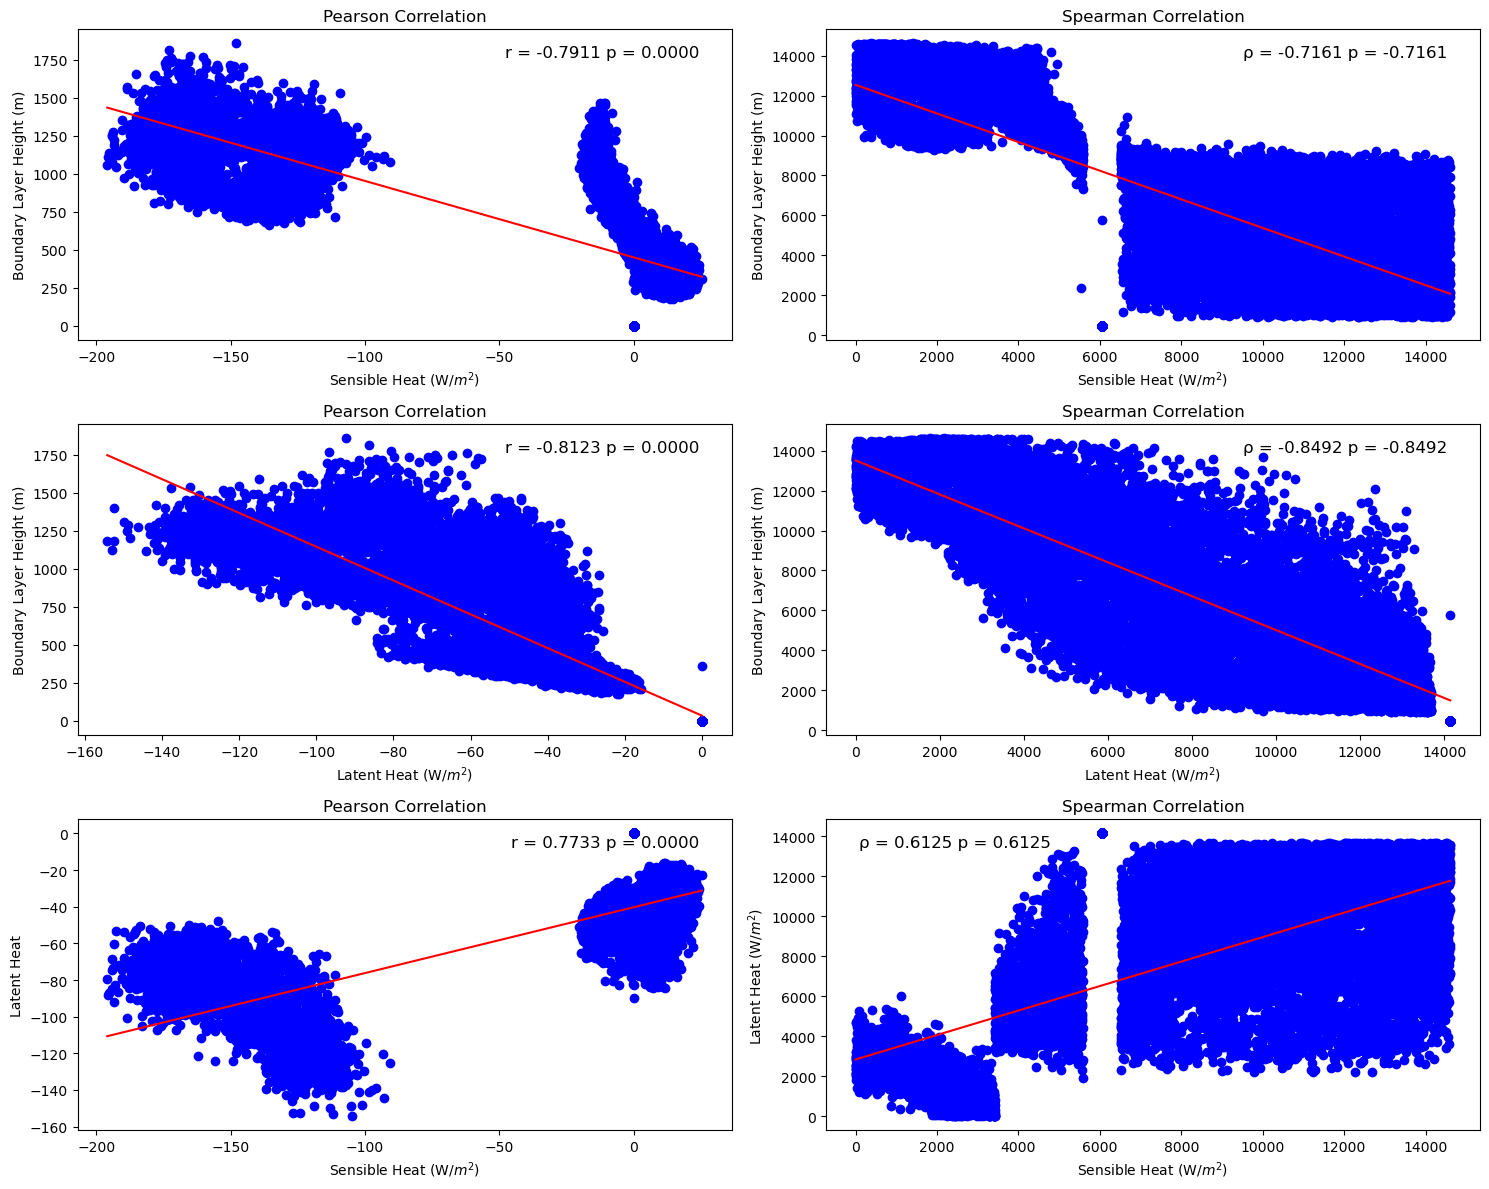

In [30]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))

# Plot on the first subplot (0,0)
ax1 = axes[0, 0]
pearson_corr, pearson_p = pearsonr(SH,BH)
ax1.scatter(SH, BH, color='b')
axes[0, 0].plot(np.unique(SH), np.poly1d(np.polyfit(SH, BH, 1))(np.unique(SH)), color='r')
axes[0, 0].set_title('Pearson Correlation')
axes[0, 0].set_xlabel('Sensible Heat (W/$m^2$)')
axes[0, 0].set_ylabel('Boundary Layer Height (m)')
ax1.text(0.95, 0.95, f'r = {pearson_corr:.4f} p = {pearson_p:.4f}',
         fontsize=12, color='black', ha='right', va='top',
         transform=ax1.transAxes)

ax2=axes[1,0]
pearson_corr, pearson_p = pearsonr(LH,BH)
ax2.scatter(LH, BH, color='b')
ax2.plot(np.unique(LH), np.poly1d(np.polyfit(LH, BH, 1))(np.unique(LH)), color='r')
ax2.set_title('Pearson Correlation')

ax2.set_xlabel('Latent Heat (W/$m^2$)')

ax2.set_ylabel('Boundary Layer Height (m)')
ax2.text(0.95, 0.95, f'r = {pearson_corr:.4f} p = {pearson_p:.4f}',
         fontsize=12, color='black', ha='right', va='top',
         transform=ax2.transAxes)

ax3=axes[2,0]
pearson_corr, pearson_p = pearsonr(SH,LH)
ax3.scatter(SH, LH, color='b')
ax3.plot(np.unique(SH), np.poly1d(np.polyfit(SH, LH, 1))(np.unique(SH)), color='r')
ax3.set_title('Pearson Correlation')
ax3.set_xlabel('Sensible Heat (W/$m^2$)')
ax3.set_ylabel('Latent Heat')
ax3.text(0.95, 0.95, f'r = {pearson_corr:.4f} p = {pearson_p:.4f}',
         fontsize=12, color='black', ha='right', va='top',
         transform=ax3.transAxes)


SH_rank = SH.rank(dim='time')
BH_rank = BH.rank(dim='time')
LH_rank = LH.rank(dim='time')
# Flatten the DataArrays for correlation and plotting
SH_rank_flat = SH_rank.values.flatten()
BH_rank_flat = BH_rank.values.flatten()
LH_rank_flat = LH_rank.values.flatten()
# Compute Spearman correlation
spearman_corr, spearman_p = spearmanr(SH_rank_flat, BH_rank_flat)

spearman_corr, spearman_p = spearmanr(SH, BH)
axes[0,1].scatter(SH_rank_flat, BH_rank_flat, color='b')
# Fit line
fit_line = np.poly1d(np.polyfit(SH_rank_flat, BH_rank_flat, 1))
axes[0,1].plot(np.unique(SH_rank_flat), fit_line(np.unique(SH_rank_flat)), color='r')

# Set titles and labels
axes[0,1].set_title('Spearman Correlation')
axes[0,1].set_xlabel('Sensible Heat (W/$m^2$)')
axes[0,1].set_ylabel('Boundary Layer Height (m)')
axes[0,1].text(0.95, 0.95, f'ρ = {spearman_corr:.4f} p = {spearman_corr:.4f}',
         fontsize=12, color='black', ha='right', va='top',
         transform=axes[0,1].transAxes)

ax4=axes[1,1]
spearman_corr, spearman_p = spearmanr(LH_rank_flat, BH_rank_flat)
spearman_corr, spearman_p = spearmanr(LH, BH)
ax4.scatter(LH_rank_flat, BH_rank_flat, color='b')
fit_line = np.poly1d(np.polyfit(LH_rank_flat, BH_rank_flat, 1))
ax4.plot(np.unique(LH_rank_flat), fit_line(np.unique(LH_rank_flat)), color='r')
ax4.set_title('Spearman Correlation')
ax4.set_xlabel('Latent Heat (W/$m^2$)')
ax4.set_ylabel('Boundary Layer Height (m)')
ax4.text(0.95, 0.95, f'ρ = {spearman_corr:.4f} p = {spearman_corr:.4f}',
         fontsize=12, color='black', ha='right', va='top',
         transform=ax4.transAxes)


ax5=axes[2,1]
spearman_corr, spearman_p = spearmanr(SH_rank_flat, LH_rank_flat)
spearman_corr, spearman_p = spearmanr(SH, LH)
ax5.scatter(SH_rank_flat, LH_rank_flat, color='b')
fit_line = np.poly1d(np.polyfit(SH_rank_flat, LH_rank_flat, 1))
ax5.plot(np.unique(SH_rank_flat), fit_line(np.unique(SH_rank_flat)), color='r')
ax5.set_title('Spearman Correlation')
ax5.set_xlabel('Sensible Heat (W/$m^2$) ')
ax5.set_ylabel('Latent Heat (W/$m^2$) ')
ax5.text(0.05, 0.95, f'ρ = {spearman_corr:.4f} p = {spearman_corr:.4f}',
         fontsize=12, color='black', ha='left', va='top',
         transform=ax5.transAxes)





plt.tight_layout()
plt.savefig('spearman correlation')
# Show the plot
plt.show()
# plt.savefig('BL.svg')

In [31]:
y = BLH
y1 = SSH
y2 = SLH
x = [0,6,12,18]
hours=[0,6,12,18]

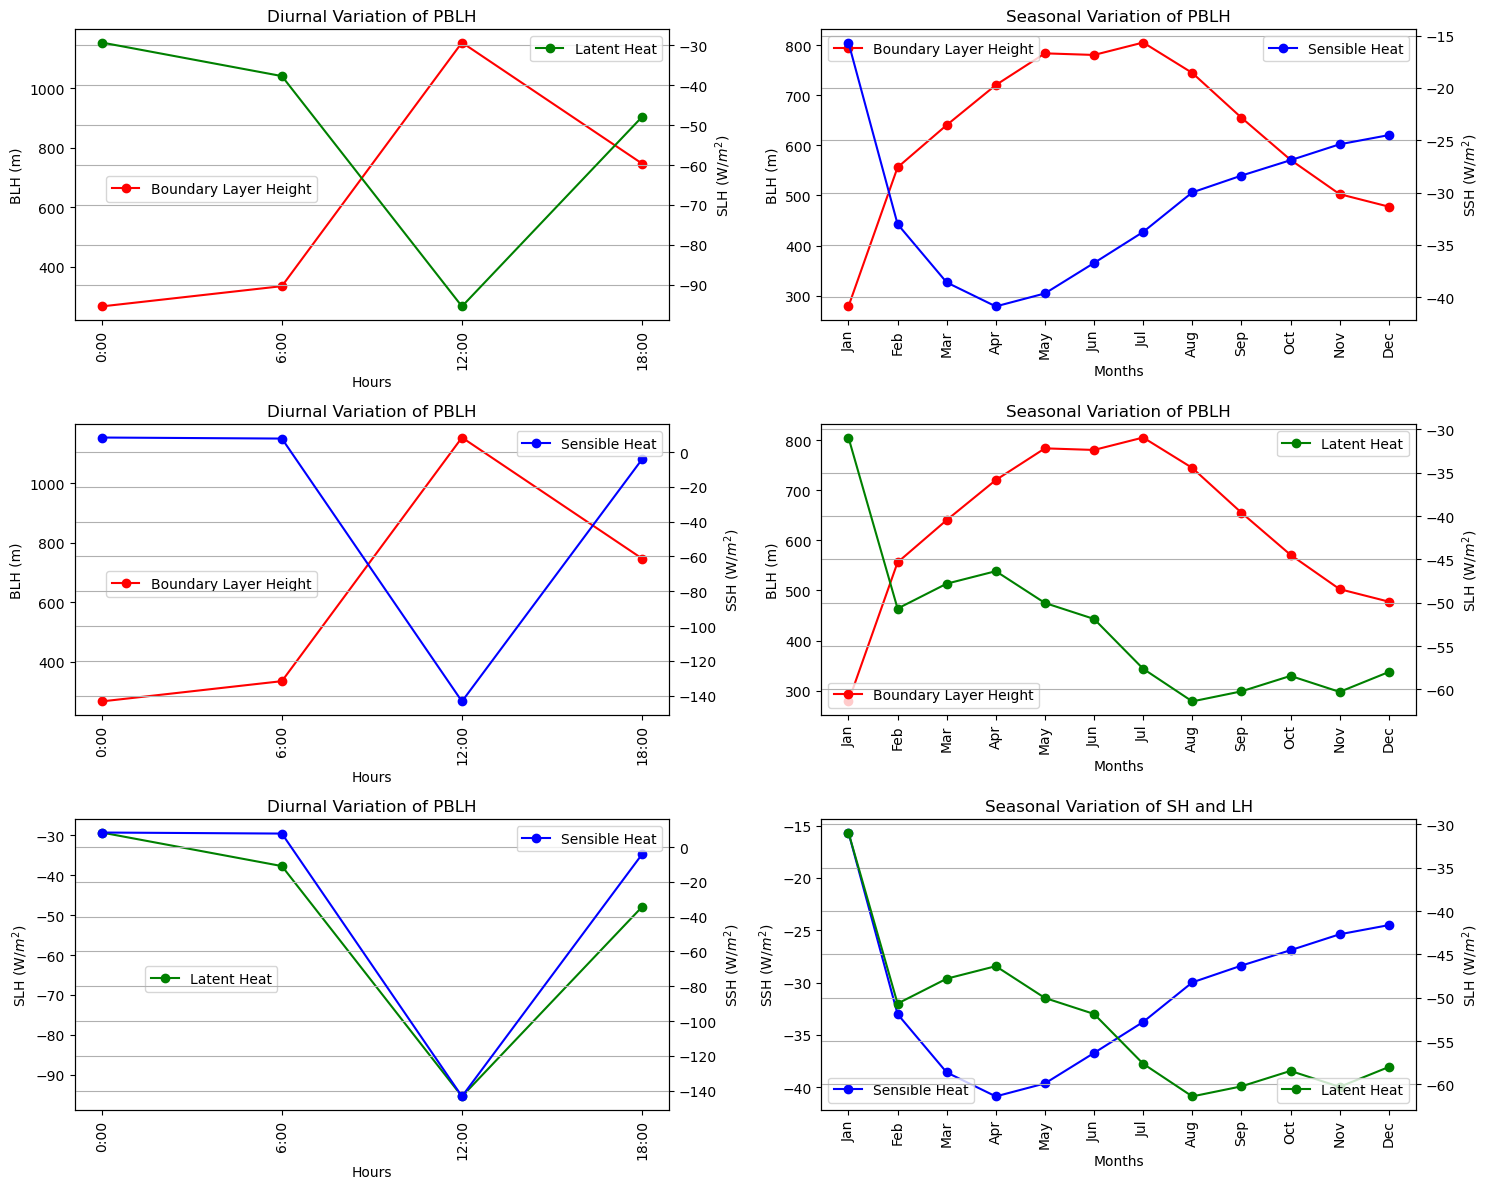

In [32]:
months = [ 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'] 


fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))

# Plot on the first subplot (0,0)
ax1 = axes[0, 0]
ax1.plot(x, BLH, color='r',  marker='o',label='Boundary Layer Height')
ax1.set_xlabel('Hours')
ax1.set_ylabel('BLH (m)')
ax1.legend(loc='center',bbox_to_anchor=(0.23, 0.45))
ax1.set_xticks(hours)  # Set x-axis ticks
ax1.set_xticklabels([f'{hour}:00' for hour in hours], rotation=90)  # Customize x-axis labels
ax1.set_title('Diurnal Variation of PBLH')
# ax1.legend(loc='upper left')
# Create a twin axis to overlay SLH data
ax1_twin = ax1.twinx()
ax1_twin.plot(x, SLH, color='g',  marker='o',label='Latent Heat' , alpha= 1.0)
ax1_twin.set_ylabel('SLH (W/$m^2$)')
ax1_twin.legend(loc='upper right')
ax1_twin.grid(True)

# Plot on the first subplot (1,0)
ax2 = axes[1, 0]
ax2.plot(x, BLH, color='r', marker='o', label='Boundary Layer Height')
ax2.set_xlabel('Hours')
ax2.set_ylabel('BLH (m)')
ax2.legend(loc='center',bbox_to_anchor=(0.23, 0.45))
ax2.set_xticks(hours)  # Set x-axis ticks
ax2.set_xticklabels([f'{hour}:00' for hour in hours], rotation=90)  # Customize x-axis labels
ax2.set_title('Diurnal Variation of PBLH')
# ax1.legend(loc='upper left')
# Create a twin axis to overlay SLH data
ax2_twin = ax2.twinx()
ax2_twin.plot(x, SSH, color='b', marker='o', label='Sensible Heat' , alpha= 1.0)
ax2_twin.set_ylabel('SSH (W/$m^2$)')
ax2_twin.legend(loc='upper right')
ax2_twin.grid(True)


# Plot on the first subplot (2,0)
ax3 = axes[2, 0]
ax3.plot(x, SLH, color='g', marker='o', label='Latent Heat')
ax3.set_xlabel('Hours')
ax3.set_ylabel('SLH (W/$m^2$)')
ax3.legend(loc='center',bbox_to_anchor=(0.23, 0.45))
ax3.set_xticks(hours)  # Set x-axis ticks
ax3.set_xticklabels([f'{hour}:00' for hour in hours], rotation=90)  # Customize x-axis labels
ax3.set_title('Diurnal Variation of PBLH')
# ax1.legend(loc='upper left')
# Create a twin axis to overlay SLH data
ax3_twin = ax3.twinx()
ax3_twin.plot(x, SSH, color='b', marker='o', label='Sensible Heat' , alpha= 1.0)
ax3_twin.set_ylabel('SSH (W/$m^2$)')
ax3_twin.legend(loc='upper right')
ax3_twin.grid(True)

ax4 = axes[0, 1]
ax4.plot(BLH_month.month,BLH_month, color='r',  marker='o',label='Boundary Layer Height')
ax4.set_xlabel('Months')
ax4.set_ylabel('BLH (m)')
ax4.legend(loc='upper left')#bbox_to_anchor=(0.23, 0.45))
ax4.set_xticks(BLH_month.month)  # Set x-axis ticks
ax4.set_xticklabels(months, rotation=90)  # Customize x-axis labels
ax4.set_title('Seasonal Variation of PBLH')
# ax1.legend(loc='upper left')
# Create a twin axis to overlay SLH data
ax4_twin = ax4.twinx()
ax4_twin.plot(SSH_month.month,SSH_month, color='b', marker='o', label='Sensible Heat' , alpha= 1.0)
ax4_twin.set_ylabel('SSH (W/$m^2$)')
ax4_twin.legend(loc='upper right')
ax4_twin.grid(True)

ax5 = axes[1, 1]
ax5.plot(BLH_month.month,BLH_month, color='r', marker='o', label='Boundary Layer Height')
ax5.set_xlabel('Months')
ax5.set_ylabel('BLH (m)')
ax5.legend(loc='lower left')#bbox_to_anchor=(0.23, 0.45))
ax5.set_xticks(BLH_month.month)  # Set x-axis ticks
ax5.set_xticklabels(months, rotation=90)  # Customize x-axis labels
ax5.set_title('Seasonal Variation of PBLH')
# ax1.legend(loc='upper left')
# Create a twin axis to overlay SLH data
ax5_twin = ax5.twinx()
ax5_twin.plot(SLH_month.month,SLH_month, color='g', marker='o', label='Latent Heat' , alpha= 1.0)
ax5_twin.set_ylabel('SLH (W/$m^2$)')
ax5_twin.legend(loc='upper right')
ax5_twin.grid(True)

ax6 = axes[2, 1]
ax6.plot(SSH_month.month,SSH_month, color='b', marker='o', label='Sensible Heat')
ax6.set_xlabel('Months')
ax6.set_ylabel('SSH (W/$m^2$)')
ax6.legend(loc='lower left')#bbox_to_anchor=(0.23, 0.45))
ax6.set_xticks(BLH_month.month)  # Set x-axis ticks
ax6.set_xticklabels(months, rotation=90)  # Customize x-axis labels
ax6.set_title('Seasonal Variation of SH and LH')
# ax1.legend(loc='upper left')
# Create a twin axis to overlay SLH data
ax6_twin = ax6.twinx()
ax6_twin.plot(SLH_month.month,SLH_month, color='g', marker='o', label='Latent Heat' , alpha= 1.0)
ax6_twin.set_ylabel('SLH (W/$m^2$)')
ax6_twin.legend(loc='lower right')
ax6_twin.grid(True)
# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()
#plt.savefig('BL.svg')

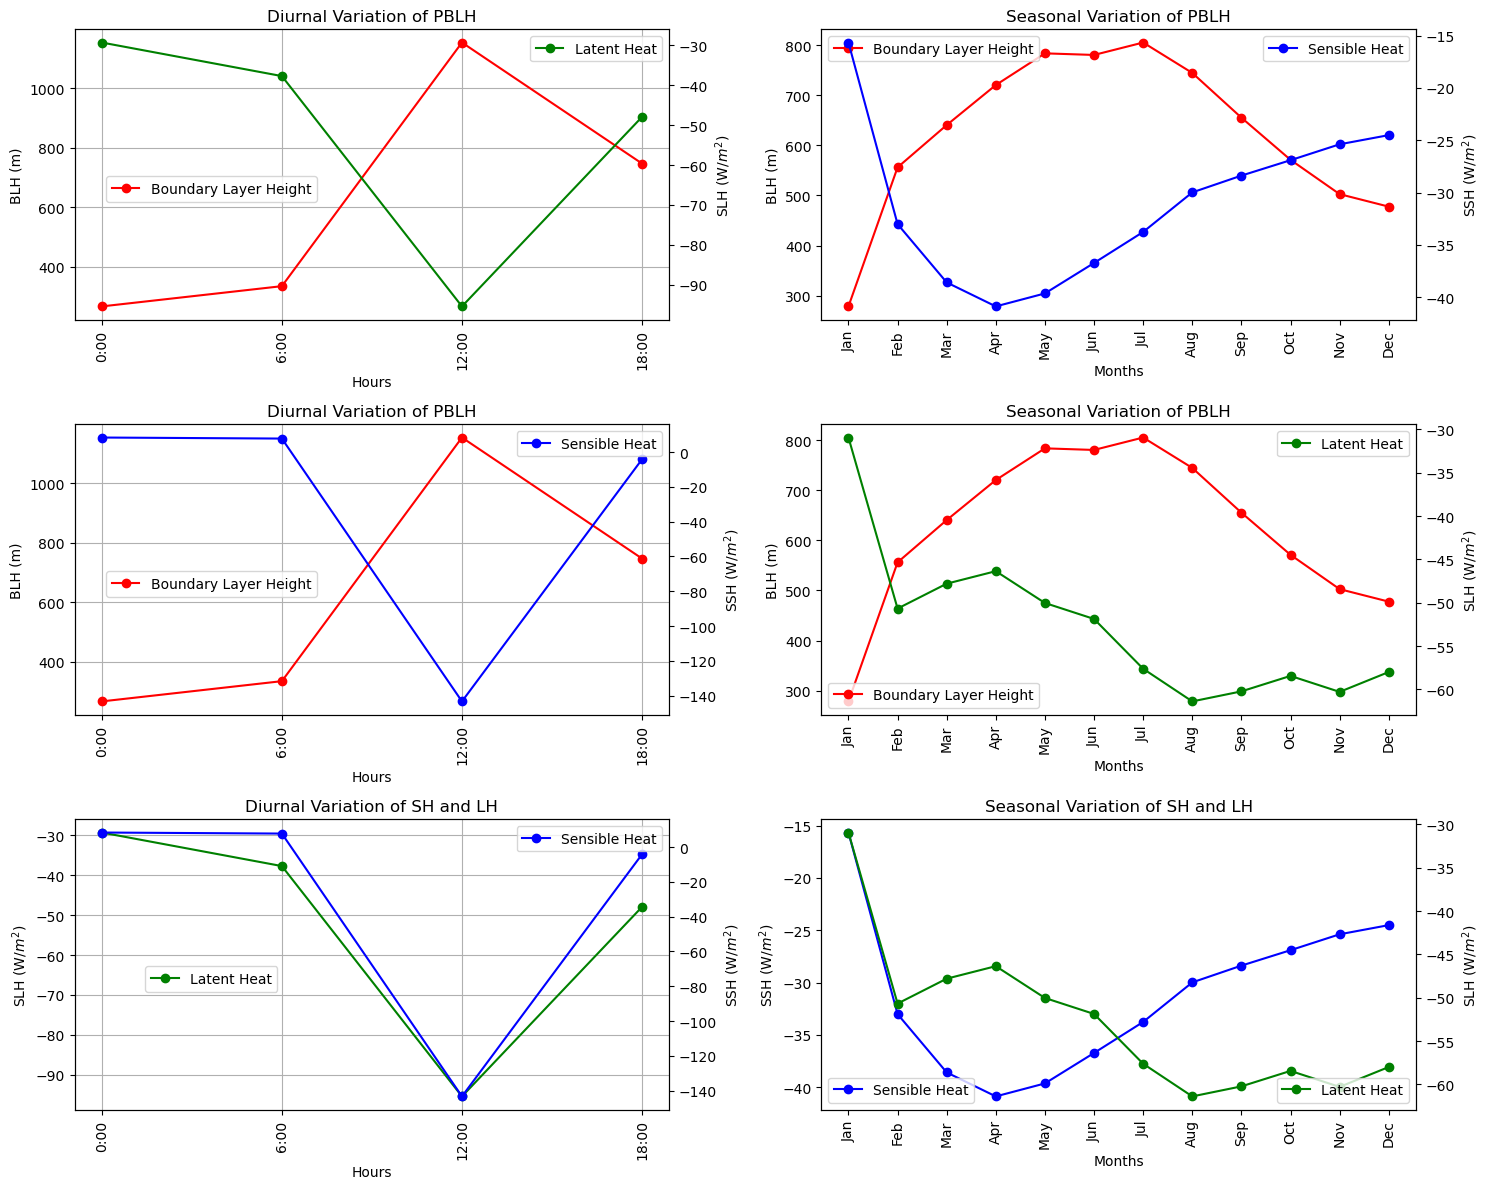

In [33]:
months = [ 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'] 

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))

# Plot on the first subplot (0,0)
ax1 = axes[0, 0]
ax1.plot(x, BLH, color='r', marker='o', label='Boundary Layer Height')
ax1.set_xlabel('Hours')
ax1.set_ylabel('BLH (m)')
ax1.legend(loc='center', bbox_to_anchor=(0.23, 0.45))
ax1.set_xticks(hours)  # Set x-axis ticks
ax1.set_xticklabels([f'{hour}:00' for hour in hours], rotation=90)  # Customize x-axis labels
ax1.set_title('Diurnal Variation of PBLH')
ax1.grid(True)  # Add both vertical and horizontal grid lines
# Create a twin axis to overlay SLH data
ax1_twin = ax1.twinx()
ax1_twin.plot(x, SLH, color='g', marker='o', label='Latent Heat', alpha=1.0)
ax1_twin.set_ylabel('SLH (W/$m^2$)')
ax1_twin.legend(loc='upper right')

# Plot on the second subplot (1,0)
ax2 = axes[1, 0]
ax2.plot(x, BLH, color='r', marker='o', label='Boundary Layer Height')
ax2.set_xlabel('Hours')
ax2.set_ylabel('BLH (m)')
ax2.legend(loc='center', bbox_to_anchor=(0.23, 0.45))
ax2.set_xticks(hours)
ax2.set_xticklabels([f'{hour}:00' for hour in hours], rotation=90)
ax2.set_title('Diurnal Variation of PBLH')
ax2.grid(True)  # Add both vertical and horizontal grid lines
# Create a twin axis to overlay SSH data
ax2_twin = ax2.twinx()
ax2_twin.plot(x, SSH, color='b', marker='o', label='Sensible Heat', alpha=1.0)
ax2_twin.set_ylabel('SSH (W/$m^2$)')
ax2_twin.legend(loc='upper right')

# Plot on the third subplot (2,0)
ax3 = axes[2, 0]
ax3.plot(x, SLH, color='g', marker='o', label='Latent Heat')
ax3.set_xlabel('Hours')
ax3.set_ylabel('SLH (W/$m^2$)')
ax3.legend(loc='center', bbox_to_anchor=(0.23, 0.45))
ax3.set_xticks(hours)
ax3.set_xticklabels([f'{hour}:00' for hour in hours], rotation=90)
ax3.set_title('Diurnal Variation of SH and LH')
ax3.grid(True)  # Add both vertical and horizontal grid lines
# Create a twin axis to overlay SSH data
ax3_twin = ax3.twinx()
ax3_twin.plot(x, SSH, color='b', marker='o', label='Sensible Heat', alpha=1.0)
ax3_twin.set_ylabel('SSH (W/$m^2$)')
ax3_twin.legend(loc='upper right')

# Plot on the fourth subplot (0,1) for seasonal variation
ax4 = axes[0, 1]
ax4.plot(BLH_month.month, BLH_month, color='r', marker='o', label='Boundary Layer Height')
ax4.set_xlabel('Months')
ax4.set_ylabel('BLH (m)')
ax4.legend(loc='upper left')
ax4.set_xticks(BLH_month.month)
ax4.set_xticklabels(months, rotation=90)
ax4.set_title('Seasonal Variation of PBLH')
ax4.grid(False)  # Remove grid lines for PBLH
# Create a twin axis to overlay SSH data
ax4_twin = ax4.twinx()
ax4_twin.plot(SSH_month.month, SSH_month, color='b', marker='o', label='Sensible Heat', alpha=1.0)
ax4_twin.set_ylabel('SSH (W/$m^2$)')
ax4_twin.legend(loc='upper right')
ax4_twin.grid(False)  # Remove grid lines for SSH

# Plot on the fifth subplot (1,1) for seasonal variation
ax5 = axes[1, 1]
ax5.plot(BLH_month.month, BLH_month, color='r', marker='o', label='Boundary Layer Height')
ax5.set_xlabel('Months')
ax5.set_ylabel('BLH (m)')
ax5.legend(loc='lower left')
ax5.set_xticks(BLH_month.month)
ax5.set_xticklabels(months, rotation=90)
ax5.set_title('Seasonal Variation of PBLH')
ax5.grid(False)  # Remove grid lines for PBLH
# Create a twin axis to overlay SLH data
ax5_twin = ax5.twinx()
ax5_twin.plot(SLH_month.month, SLH_month, color='g', marker='o', label='Latent Heat', alpha=1.0)
ax5_twin.set_ylabel('SLH (W/$m^2$)')
ax5_twin.legend(loc='upper right')
ax5_twin.grid(False)  # Remove grid lines for SLH

# Plot on the sixth subplot (2,1) for seasonal variation
ax6 = axes[2, 1]
ax6.plot(SSH_month.month, SSH_month, color='b', marker='o', label='Sensible Heat')
ax6.set_xlabel('Months')
ax6.set_ylabel('SSH (W/$m^2$)')
ax6.legend(loc='lower left')
ax6.set_xticks(BLH_month.month)
ax6.set_xticklabels(months, rotation=90)
ax6.set_title('Seasonal Variation of SH and LH')
ax6.grid(False)  # Remove grid lines for SSH
# Create a twin axis to overlay SLH data
ax6_twin = ax6.twinx()
ax6_twin.plot(SLH_month.month, SLH_month, color='g', marker='o', label='Latent Heat', alpha=1.0)
ax6_twin.set_ylabel('SLH (W/$m^2$)')
ax6_twin.legend(loc='lower right')
ax6_twin.grid(False)  # Remove grid lines for SLH

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.savefig('timeseries')
plt.show()
#plt.savefig('BL.svg')

In [34]:
bl = SHZ_BLH
lh = SHZ_SLH
sh = SHZ_SH
x = [0,6,12,18]
hours=[0,6,12,18]

y3=GZ_BLH
y4=GZ_SLH
y5=GZ_SH

y6=SS_BLH
y7=SS_SLH
y8=SS_SH

y9=SZ_BLH
y10=SZ_SLH
y11=SZ_SH

# ----------------------------------------------------------------------------------------------

In [ ]:
# DIURNAL VARIATIONS
# Sahel 
SHZ_BLH = 163.3693078 ,  241.83094377, 1363.21511394,  592.33480933
SHZ_SH = 17.10416066,   17.96777195, -226.24156499,    1.06914712
SHZ_SLH = -7.73616001,   -9.47822635, -113.71347082,  -31.92870002

# Guinea
GZ_BLH = 267.01771327, 331.52742872, 927.27965131, 399.67623466
GZ_SH = 1.3199239 ,   -2.73188036, -120.22872774,    0.86798626
GZ_SLH = -30.264291  ,  -39.68767611, -176.47246118,  -61.99646689

# Sudano_Sahelian
SS_BLH = 164.52969719,  246.56302843, 1270.58544611,  320.10532642
SS_SH = 9.82990481,    7.66706257, -209.5456856 ,    5.0892591
SS_SLH = -13.05354827,  -17.20728154, -192.50770953,  -46.89553986

# Sudan 
SZ_BLH = 154.19631812,  196.07724237, 1303.4400536 ,  943.49034888
SZ_SH =  16.41754298,   21.15240625, -185.97840362,   -6.85231198
SZ_SLH = -5.53746666,  -7.1255888 , -18.82426259, -10.40685492

In [ ]:
#  SEASONAL VARIATION

# sudan
SZ_SH_month = -12.40565315, -27.94220331, -36.04202327, -41.08450258,-44.42686205, -47.71162878, -55.40645402, -52.00928612,-45.47098052, -35.17250044, -26.31986715, -20.78679623
SZ_BLH_month = 209.35817631, 436.4701452 , 530.79506069, 704.23973801,907.1676808 , 967.740367  , 934.49790603, 838.52782673,823.51805494, 673.81412274, 413.17598591, 361.68754233
SZ_SLH_month = -4.87738698,  -7.18342269,  -6.06375472,  -5.96361746,-6.64987709,  -8.4952557 , -13.62630032, -26.12564437, -17.48503685, -11.1927724 , -10.24696486, -10.13943769

# Sudano_Sahelian
SS_SH_month = -30.17136178, -62.75771257, -72.38158727, -71.16311681,-56.36724791, -38.94636414, -27.0883778 , -20.54627171,-23.86450949, -31.83535542, -41.5018762 , -46.32133355
SS_BLH_month = 249.70251755, 522.94837402, 665.3583472 , 704.0639812 ,614.61644229, 527.34291704, 469.90612984, 431.37526384, 378.83804985, 427.03092236, 488.57024284, 439.40279609
SS_SLH_month = -26.34462811, -40.11319283, -41.86403963, -52.02360857,-69.92846973, -82.37734856, -89.23220873, -88.91411564,-94.09226429, -93.09121469, -73.97573585, -56.20137292

# Guinea_zone
GZ_SH_month = -25.37209521, -48.34492059, -41.11312383, -32.86288356,-26.2881896 , -21.44326938, -19.82970666, -19.60379494,-19.67753785, -21.80991174, -26.81608327, -35.34081902
GZ_BLH_month = 300.45097344, 568.30776127, 565.16963689, 523.88964553,472.06140644, 479.1772071 , 525.59981109, 523.58091645,440.40959454, 415.18264562, 455.43662175, 484.04830506
GZ_SLH_month = -36.88643172, -63.27734122, -74.57393571, -83.82638225,-86.87917315, -89.9763389 , -90.58804695, -84.05001997,-79.25543273, -81.60172007, -81.84835621, -71.4867231 

#  Sahel 
SHZ_SH_month = -20.67451448, -43.40367163, -54.54722591, -63.55599106,-67.68578085, -64.32918141, -48.82370857, -30.1370594 ,-35.1185858 , -40.72490068, -36.22668184, -33.45346843
SHZ_BLH_month = 225.31219231, 484.30051542, 641.16436587, 842.34788313,884.07816788, 794.09604507, 673.3363259 , 530.89297006,520.85857944, 579.17107544, 467.65767088, 390.14763793
SHZ_SLH_month = -13.63962292, -19.94106131, -17.4036849 , -17.57532748,-25.07882503, -41.41560109, -65.03543752, -83.07222496,-80.11026821, -58.44416046, -41.19083659, -30.33541173


In [ ]:
import matplotlib.pyplot as plt

# Diurnal Data
x = [0, 6, 12, 18]
hours = [0, 6, 12, 18]

# Sahel Zone
SHZ_BLH = [163.3693078, 241.83094377, 1363.21511394, 592.33480933]
SHZ_SH = [17.10416066, 17.96777195, -226.24156499, 1.06914712]
SHZ_SLH = [-7.73616001, -9.47822635, -113.71347082, -31.92870002]

# Guinea Zone
GZ_BLH = [267.01771327, 331.52742872, 927.27965131, 399.67623466]
GZ_SH = [1.3199239, -2.73188036, -120.22872774, 0.86798626]
GZ_SLH = [-30.264291, -39.68767611, -176.47246118, -61.99646689]

# Sudano-Sahelian Zone
SS_BLH = [164.52969719, 246.56302843, 1270.58544611, 320.10532642]
SS_SH = [9.82990481, 7.66706257, -209.5456856, 5.0892591]
SS_SLH = [-13.05354827, -17.20728154, -192.50770953, -46.89553986]

# Sudan Zone
SZ_BLH = [154.19631812, 196.07724237, 1303.4400536, 943.49034888]
SZ_SH = [16.41754298, 21.15240625, -185.97840362, -6.85231198]
SZ_SLH = [-5.53746666, -7.1255888, -18.82426259, -10.40685492]

# Seasonal Data
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Sudan Zone (Seasonal)
SZ_SH_month = [-12.40565315, -27.94220331, -36.04202327, -41.08450258, -44.42686205, -47.71162878, -55.40645402, -52.00928612, -45.47098052, -35.17250044, -26.31986715, -20.78679623]
SZ_BLH_month = [209.35817631, 436.4701452, 530.79506069, 704.23973801, 907.1676808, 967.740367, 934.49790603, 838.52782673, 823.51805494, 673.81412274, 413.17598591, 361.68754233]
SZ_SLH_month = [-4.87738698, -7.18342269, -6.06375472, -5.96361746, -6.64987709, -8.4952557, -13.62630032, -26.12564437, -17.48503685, -11.1927724, -10.24696486, -10.13943769]

# Sudano-Sahelian Zone (Seasonal)
SS_SH_month = [-30.17136178, -62.75771257, -72.38158727, -71.16311681, -56.36724791, -38.94636414, -27.0883778, -20.54627171, -23.86450949, -31.83535542, -41.5018762, -46.32133355]
SS_BLH_month = [249.70251755, 522.94837402, 665.3583472, 704.0639812, 614.61644229, 527.34291704, 469.90612984, 431.37526384, 378.83804985, 427.03092236, 488.57024284, 439.40279609]
SS_SLH_month = [-26.34462811, -40.11319283, -41.86403963, -52.02360857, -69.92846973, -82.37734856, -89.23220873, -88.91411564, -94.09226429, -93.09121469, -73.97573585, -56.20137292]

# Guinea Zone (Seasonal)
GZ_SH_month = [-25.37209521, -48.34492059, -41.11312383, -32.86288356, -26.2881896, -21.44326938, -19.82970666, -19.60379494, -19.67753785, -21.80991174, -26.81608327, -35.34081902]
GZ_BLH_month = [300.45097344, 568.30776127, 565.16963689, 523.88964553, 472.06140644, 479.1772071, 525.59981109, 523.58091645, 440.40959454, 415.18264562, 455.43662175, 484.04830506]
GZ_SLH_month = [-36.88643172, -63.27734122, -74.57393571, -83.82638225, -86.87917315, -89.9763389, -90.58804695, -84.05001997, -79.25543273, -81.60172007, -81.84835621, -71.4867231]

# Sahel Zone (Seasonal)
SHZ_SH_month = [-20.67451448, -43.40367163, -54.54722591, -63.55599106, -67.68578085, -64.32918141, -48.82370857, -30.1370594, -35.1185858, -40.72490068, -36.22668184, -33.45346843]
SHZ_BLH_month = [225.31219231, 484.30051542, 641.16436587, 842.34788313, 884.07816788, 794.09604507, 673.3363259, 530.89297006, 520.85857944, 579.17107544, 467.65767088, 390.14763793]
SHZ_SLH_month = [-13.63962292, -19.94106131, -17.4036849, -17.57532748, -25.07882503, -41.41560109, -65.03543752, -83.07222496, -80.11026821, -58.44416046, -41.19083659, -30.33541173]

# Create subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(18, 20))

# Diurnal Variation - Sahel Zone
ax1 = axes[0, 0]
ax1.plot(x, SHZ_BLH, color='r', marker='o', label='Boundary Layer Height')
ax1.set_xlabel('Hours')
ax1.set_ylabel('PBLH (m)')
ax1.set_ylim(0, 1400)
ax1.legend(loc='upper left')
ax1.set_xticks(hours)
ax1.set_xticklabels([f'{hour}:00' for hour in hours], rotation=45)
ax1.set_title('Diurnal Variation of PBLH, SH, and LH Over Sahel')
ax1_twin = ax1.twinx()
ax1_twin.plot(x, SHZ_SH, color='g', marker='o', label='Sensible Heat', alpha=0.7)
ax1_twin.plot(x, SHZ_SLH, color='b', marker='o', label='Latent Heat', alpha=0.7)
ax1_twin.set_ylabel('Surface Fluxes (W/$m^2$)')
ax1_twin.legend(loc='upper right')
ax1_twin.grid(True)

# Diurnal Variation - Guinea Zone
ax2 = axes[1, 0]
ax2.plot(x, GZ_BLH, color='r', marker='o', label='Boundary Layer Height')
ax2.set_xlabel('Hours')
ax2.set_ylabel('PBLH (m)')
ax2.set_ylim(0, 1400)
ax2.legend(loc='upper left')
ax2.set_xticks(hours)
ax2.set_xticklabels([f'{hour}:00' for hour in hours], rotation=45)
ax2.set_title('Diurnal Variation of PBLH, SH, and LH Over Guinea')
ax2_twin = ax2.twinx()
ax2_twin.plot(x, GZ_SH, color='g', marker='o', label='Sensible Heat', alpha=0.7)
ax2_twin.plot(x, GZ_SLH, color='b', marker='o', label='Latent Heat', alpha=0.7)
ax2_twin.set_ylabel('Surface Fluxes (W/$m^2$)')
ax2_twin.legend(loc='upper right')
ax2_twin.grid(True)

# Diurnal Variation - Sudano-Sahelian Zone
ax3 = axes[2, 0]
ax3.plot(x, SS_BLH, color='r', marker='o', label='Boundary Layer Height')
ax3.set_xlabel('Hours')
ax3.set_ylabel('PBLH (m)')
ax3.set_ylim(0, 1400)
ax3.legend(loc='upper left')
ax3.set_xticks(hours)
ax3.set_xticklabels([f'{hour}:00' for hour in hours], rotation=45)
ax3.set_title('Diurnal Variation of PBLH, SH, and LH Over Sudano-Sahelian')
ax3_twin = ax3.twinx()
ax3_twin.plot(x, SS_SH, color='g', marker='o', label='Sensible Heat', alpha=0.7)
ax3_twin.plot(x, SS_SLH, color='b', marker='o', label='Latent Heat', alpha=0.7)
ax3_twin.set_ylabel('Surface Fluxes (W/$m^2$)')
ax3_twin.legend(loc='upper right')
ax3_twin.grid(True)

# Diurnal Variation - Sudan Zone
ax4 = axes[3, 0]
ax4.plot(x, SZ_BLH, color='r', marker='o', label='Boundary Layer Height')
ax4.set_xlabel('Hours')
ax4.set_ylabel('PBLH (m)')
ax4.set_ylim(0, 1400)
ax4.legend(loc='upper left')
ax4.set_xticks(hours)
ax4.set_xticklabels([f'{hour}:00' for hour in hours], rotation=45)
ax4.set_title('Diurnal Variation of PBLH, SH, and LH Over Sudan')
ax4_twin = ax4.twinx()
ax4_twin.plot(x, SZ_SH, color='g', marker='o', label='Sensible Heat', alpha=0.7)
ax4_twin.plot(x, SZ_SLH, color='b', marker='o', label='Latent Heat', alpha=0.7)
ax4_twin.set_ylabel('Surface Fluxes (W/$m^2$)')
ax4_twin.legend(loc='upper right')
ax4_twin.grid(True)

# Seasonal Variation - Sahel Zone
ax5 = axes[0, 1]
ax5.plot(months, SHZ_BLH_month, color='r', marker='o', label='Boundary Layer Height')
ax5.set_xlabel('Months')
ax5.set_ylabel('PBLH (m)')
ax5.set_ylim(0, 1000)
ax5.legend(loc='upper left')
ax5.set_title('Seasonal Variation of PBLH, SH, and LH Over Sahel')
ax5_twin = ax5.twinx()
ax5_twin.plot(months, SHZ_SH_month, color='g', marker='o', label='Sensible Heat', alpha=0.7)
ax5_twin.plot(months, SHZ_SLH_month, color='b', marker='o', label='Latent Heat', alpha=0.7)
ax5_twin.set_ylabel('Surface Fluxes (W/$m^2$)')
ax5_twin.legend(loc='upper right')
# ax5_twin.grid(True)

# Seasonal Variation - Guinea Zone
ax6 = axes[1, 1]
ax6.plot(months, GZ_BLH_month, color='r', marker='o', label='Boundary Layer Height')
ax6.set_xlabel('Months')
ax6.set_ylabel('PBLH (m)')
ax6.set_ylim(0, 1000)
ax6.legend(loc='upper left')
ax6.set_title('Seasonal Variation of PBLH, SH, and LH Over Guinea')
ax6_twin = ax6.twinx()
ax6_twin.plot(months, GZ_SH_month, color='g', marker='o', label='Sensible Heat', alpha=0.7)
ax6_twin.plot(months, GZ_SLH_month, color='b', marker='o', label='Latent Heat', alpha=0.7)
ax6_twin.set_ylabel('Surface Fluxes (W/$m^2$)')
ax6_twin.legend(loc='upper right')
# ax6_twin.grid(True)

# Seasonal Variation - Sudano-Sahelian Zone
ax7 = axes[2, 1]
ax7.plot(months, SS_BLH_month, color='r', marker='o', label='Boundary Layer Height')
ax7.set_xlabel('Months')
ax7.set_ylabel('PBLH (m)')
ax7.set_ylim(0, 1000)
ax7.legend(loc='upper left')
ax7.set_title('Seasonal Variation of PBLH, SH, and LH Over Sudano-Sahelian')
ax7_twin = ax7.twinx()
ax7_twin.plot(months, SS_SH_month, color='g', marker='o', label='Sensible Heat', alpha=0.7)
ax7_twin.plot(months, SS_SLH_month, color='b', marker='o', label='Latent Heat', alpha=0.7)
ax7_twin.set_ylabel('Surface Fluxes (W/$m^2$)')
ax7_twin.legend(loc='upper right')
# ax7_twin.grid(True)

# Seasonal Variation - Sudan Zone
ax8 = axes[3, 1]
ax8.plot(months, SZ_BLH_month, color='r', marker='o', label='Boundary Layer Height')
ax8.set_xlabel('Months')
ax8.set_ylabel('PBLH (m)')
ax8.set_ylim(0, 1000)
ax8.legend(loc='upper left')
ax8.set_title('Seasonal Variation of PBLH, SH, and LH Over Sudan')
ax8_twin = ax8.twinx()
ax8_twin.plot(months, SZ_SH_month, color='g', marker='o', label='Sensible Heat', alpha=0.7)
ax8_twin.plot(months, SZ_SLH_month, color='b', marker='o', label='Latent Heat', alpha=0.7)
ax8_twin.set_ylabel('Surface Fluxes (W/$m^2$)')
ax8_twin.legend(loc='upper right')
# ax8_twin.grid(True)

plt.tight_layout()
plt.savefig('diurnal & seasonal variations')
plt.show()
